In [1]:
from google.colab import files
uploaded = files.upload()

Saving df_prix_clean.csv to df_prix_clean.csv


In [2]:
import pandas as pd

df = pd.read_csv("df_prix_clean.csv", dtype={'code_commune_insee': str})

df['annee'] = df['annee'].astype(int)
df['code_commune_insee'] = df['code_commune_insee'].str.zfill(5)

df = df[['code_commune_insee', 'annee', 'prixm2moyen']]

df = df[df['annee'].between(2014, 2024)]
df = df.dropna()
df = df[df['prixm2moyen'] > 0]

print(df.head())
print(df.dtypes)
print(f"Nb communes : {df['code_commune_insee'].nunique()}, Nb lignes : {len(df)}")

  code_commune_insee  annee  prixm2moyen
0              01001   2014     1708.900
1              01002   2014     1338.000
2              01004   2014     1946.432
3              01005   2014     2412.200
4              01006   2014      857.000
code_commune_insee     object
annee                   int64
prixm2moyen           float64
dtype: object
Nb communes : 33148, Nb lignes : 320598


In [3]:
from prophet import Prophet

def prophet_predict_one(commune_df, code_commune):
    """
    Entraîner Prophet sur les données 2014-2024 d'une commune et prédit 2025-2029.
    Retourne un DataFrame avec code_commune_insee, année prédite, prixm2moyen_prédit.
    """

    if len(commune_df) < 5 or commune_df['prixm2moyen'].std() == 0:
        return pd.DataFrame()

    df_prophet = commune_df[['annee', 'prixm2moyen']].rename(
        columns={'annee': 'ds', 'prixm2moyen': 'y'}
    )
    df_prophet['ds'] = pd.to_datetime(df_prophet['ds'], format='%Y')

    model = Prophet(
        yearly_seasonality=False, weekly_seasonality=False, daily_seasonality=False,
        interval_width=0.80
    )
    model.fit(df_prophet)

    future_years = pd.DataFrame({'ds': pd.date_range('2025-01-01', '2029-01-01', freq='YS')})

    forecast = model.predict(future_years)

    # Récupération uniquement du point central (yhat)
    result = pd.DataFrame({
        'code_commune_insee': code_commune,
        'annee': future_years['ds'].dt.year,
        'prixm2moyen_pred': forecast['yhat'].values
    })
    return result

In [4]:
from joblib import Parallel, delayed

communes = df['code_commune_insee'].unique()

def run_prophet_for_commune(code_commune):
    commune_df = df[df['code_commune_insee'] == code_commune]
    return prophet_predict_one(commune_df, code_commune)

results = Parallel(n_jobs=-1, verbose=10)(
    delayed(run_prophet_for_commune)(code) for code in communes
)

df_pred = pd.concat([res for res in results if not res.empty], ignore_index=True)

print(df_pred.head(10))
print(f"Total communes prédites : {df_pred['code_commune_insee'].nunique()}")
print(f"Années couvertes : {df_pred['annee'].unique()}")

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   15.5s
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:   17.4s
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:   19.4s
[Parallel(n_jobs=-1)]: Done 109 tasks      | elapsed:   23.1s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:   26.6s
[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed:   

  code_commune_insee  annee  prixm2moyen_pred
0              01001   2025       2881.471400
1              01001   2026       3002.063398
2              01001   2027       3122.655396
3              01001   2028       3243.247393
4              01001   2029       3364.169780
5              01002   2025       2163.731893
6              01002   2026       2272.399277
7              01002   2027       2381.066661
8              01002   2028       2489.734046
9              01002   2029       2598.699149
Total communes prédites : 31621
Années couvertes : [2025 2026 2027 2028 2029]


Aperçu des prédictions :
         count         mean          std          min          25%  \
annee                                                                
2025   31621.0  1984.848417   984.196158 -1516.256632  1351.887744   
2026   31621.0  2035.428158  1032.170660 -2050.238947  1373.560564   
2027   31621.0  2086.007899  1081.822486 -2584.221263  1393.927550   
2028   31621.0  2136.587640  1132.931128 -3198.088179  1414.271059   
2029   31621.0  2187.305956  1185.453241 -4196.450920  1435.420430   

               50%          75%           max  
annee                                          
2025   1767.637064  2345.353657  12681.491872  
2026   1811.753584  2419.640615  13223.568878  
2027   1856.894229  2494.706424  13765.645884  
2028   1901.744179  2573.025897  14307.722889  
2029   1948.101652  2649.012506  14851.285037  


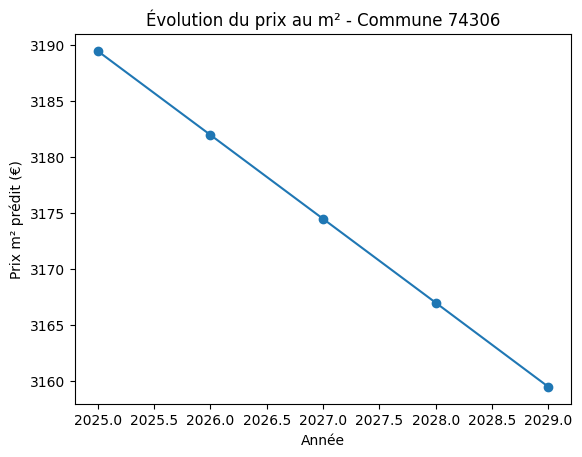

In [5]:
df_pred.to_csv("predictions_communes_2025_2029.csv", index=False)

print("Aperçu des prédictions :")
print(df_pred.groupby('annee')['prixm2moyen_pred'].describe())

import matplotlib.pyplot as plt

commune_test = df_pred['code_commune_insee'].sample(1).values[0]
df_commune = df_pred[df_pred['code_commune_insee'] == commune_test]

plt.plot(df_commune['annee'], df_commune['prixm2moyen_pred'], marker='o')
plt.title(f"Évolution du prix au m² - Commune {commune_test}")
plt.xlabel("Année")
plt.ylabel("Prix m² prédit (€)")
plt.show()